# Project 1: Market Data Collector & EDA Toolkit

## Overview
This project is the first in my **Quantitative Finance Projects** series.  
It focuses on **collecting, cleaning, and exploring market data** as the foundation for trading strategy research.

The goal is to:
- Download historical price data for a set of tickers
- Perform basic exploratory data analysis (EDA)
- Visualise important metrics such as returns, volatility, drawdowns, and correlations.

All work is documented in Jupyter Notebooks to clearly show methodology, results, and annotations.

---

## Features

- Pull OHLCV data from Yahoo Finance yfinance
- Compute:
  - Daily returns & log returns
  - Rolling volatility
  - Maximum drawdown
- Generate plots:
  - Price history
  - Rolling volatility
  - Drawdown curves
  - Correlation heatmap

---

I will begin by pulling data from yfinance for AAPL, AMZN, GOOGL, MSFT, NVDA, and TSLA.

Then we clean and format the data and extract prices, calculate returns and log returns, and drawdown.

Where simple return is given by $$r_{t} = \frac{P_{t}}{P_{t-1}} - 1$$

and log return is given by $$l_{t} = \ln{P_{t}} - \ln{P_{t-1}}$$

We finally plot Price History, Daily Returns, and Drawdown.



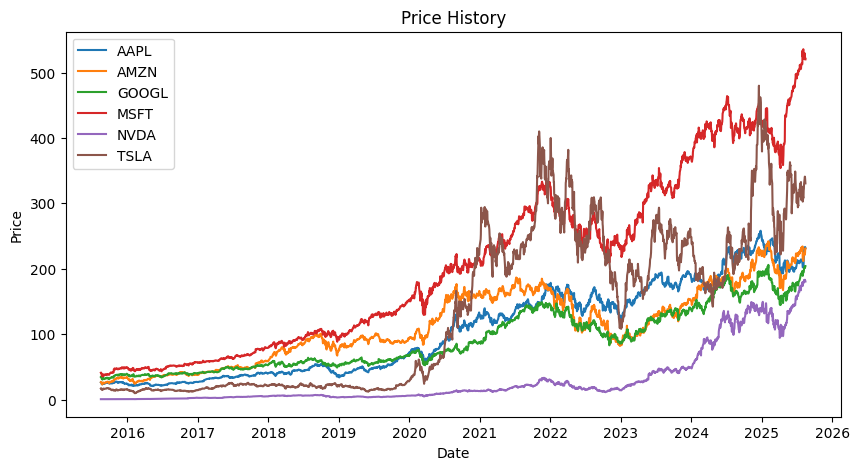

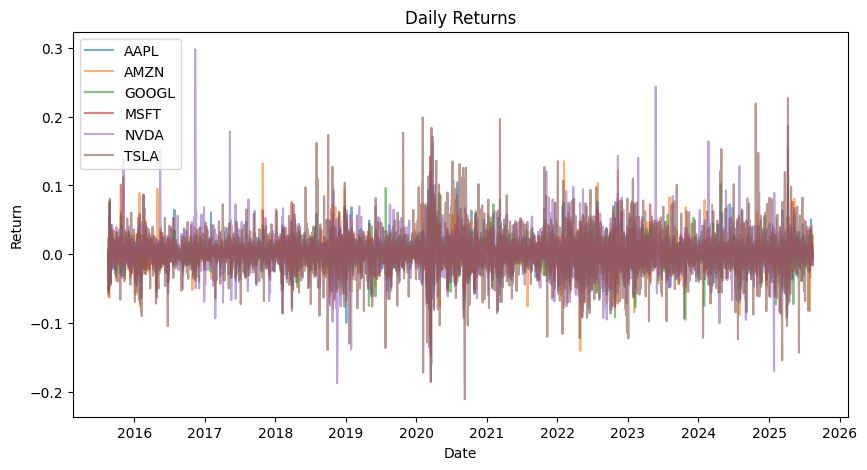

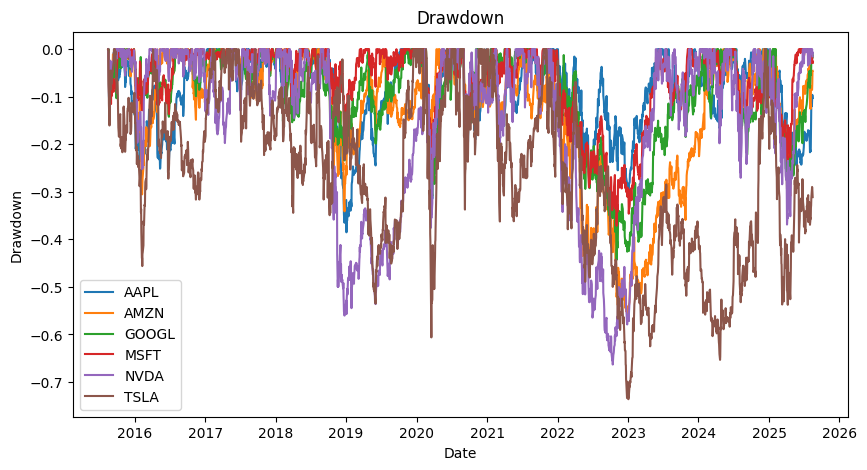

In [103]:
import os
import pathlib
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA"]
PERIOD = "10y"
INTERVAL = "1d"

frames = []

for t in TICKERS:
    df = yf.download(t, period=PERIOD, interval=INTERVAL, auto_adjust=True, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df = df.rename_axis("date").reset_index()
    df["ticker"] = t
    frames.append(df)

prices = pd.concat(frames, ignore_index=True)

close = (
    prices[["date", "ticker", "Close"]]
    .pivot(index="date", columns="ticker", values="Close")
    .sort_index())

rets = close.pct_change().dropna()

logrets = np.log(close).diff().dropna()

cumrets = (1 + rets).cumprod() - 1

plt.figure(figsize=(10,5))

for t in close.columns:
    plt.plot(close.index, close[t], label=t)
    
plt.title("Price History")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for t in rets.columns:
    plt.plot(rets.index, rets[t], label=t, alpha=0.6)

plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

def drawdown(series: pd.Series) -> pd.Series:
    peak = series.cummax()
    return series / peak - 1

plt.figure(figsize=(10,5))
for t in close.columns:
    dd = drawdown(close[t].dropna())
    plt.plot(dd.index, dd, label=t)
    
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.show()

---

Next, I want to calculate Rolling Volatility which is essentially the standard deviation of returns. We use rolling volatility as risk changes over time.

To do this, we need to take our daily returns, apply a rolling window standard deviation, and annualise it by multiplying by $\sqrt{252}$ since there are ~252 trading days per year.

This is important as it should influence decisions behind position sizing and risk control.

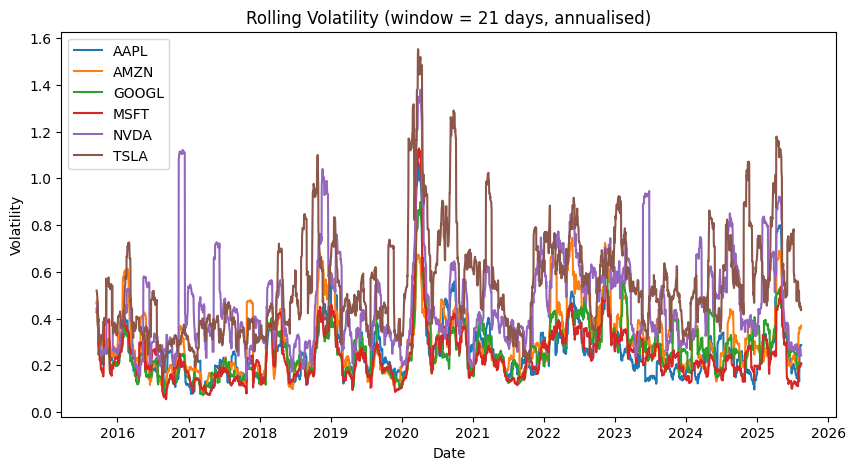

In [104]:
window = 21

roll_vol = rets.rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(10,5))
for t in roll_vol.columns:
    plt.plot(roll_vol.index, roll_vol[t], label=t)
    
plt.title(f"Rolling Volatility (window = {window} days, annualised)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

---

## Summary

Now, I want to produce a summary of important metrics such as Annualised Return, Annualised Volatility, and Sharpe Ratio (Risk Free Rate = 0).

To calculate Annualised Returns we take the cumulatuive product of daily returns and scale to 252 trading days.$$(1 + r)^{252/n} - 1$$

Annualised Volatility is calulated by scaling the daily standard deviation to 252 days.$$\sigma_{ann} = \sigma_{daily} \times \sqrt{252}$$

To calculate the reward per unit risk we need the Sharpe Ratio.$$Sharpe = \frac{Return}{Volatility}$$

In [105]:
ann_ret = (1+rets).prod() **(252/len(rets)) - 1

ann_vol = rets.std() * np.sqrt(252)

sharpe = ann_ret / ann_vol

summary = pd.DataFrame({
    "Annualised Return": ann_ret,
    "Annualised Volatility": ann_vol,
    "Sharpe (rf = 0)": sharpe
}).sort_values("Sharpe (rf = 0)", ascending=False)

summary

,Annualised Return,Annualised Volatility,Sharpe (rf = 0)
ticker,,,
NVDA,0.782159,0.499807,1.564922
MSFT,0.289932,0.271940,1.066163
AAPL,0.243524,0.293628,0.829362
AMZN,0.241195,0.329368,0.732297
GOOGL,0.194939,0.287224,0.678700
TSLA,0.346448,0.592254,0.584965


Now, we will compute the max drawdown percentage for each ticker.

In [106]:
def calculate_max_drawdown(cum_returns):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    max_dd = drawdown.min()
    return max_dd

max_drawdowns = cumrets.apply(calculate_max_drawdown)
max_drawdowns = max_drawdowns.to_frame(name="Max Drawdown (%)")
max_drawdowns

,Max Drawdown (%)
ticker,
AAPL,-5.692352
AMZN,-3.972663
GOOGL,-4.820173
MSFT,-26.153997
NVDA,-2.689111
TSLA,-13.086854


and summarise the top 3 drawdowns for each in a table.

In [107]:
def get_top_drawdowns(cum_returns, top=3):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    
    troughs = drawdown.nsmallest(top).index
    results = []
    for t in troughs:
        start = (cum_returns[:t].idxmax())
        recovery = cum_returns[t:].loc[cum_returns[t:] >= cum_returns[start]].first_valid_index()
        results.append([start, t, recovery, drawdown[t]])
    
    return pd.DataFrame(results, columns=["Start", "Trough", "Recovery", "Drawdown (%)"]) 

all_drawdowns = []

for ticker in cumrets.columns:
    df = get_top_drawdowns(cumrets[ticker],top=3)
    df["Ticker"] = ticker
    all_drawdowns.append(df)
    
top3_drawdowns = pd.concat(all_drawdowns).reset_index(drop=True)

top3_drawdowns

,Start,Trough,Recovery,Drawdown (%),Ticker
0,2015-11-03,2016-05-12,2017-01-11,-5.692352,AAPL
1,2015-11-03,2016-05-13,2017-01-11,-5.658562,AAPL
2,2015-11-03,2016-06-27,2017-01-11,-5.373133,AAPL
3,2015-09-21,2015-09-29,2015-10-12,-3.972663,AMZN
4,2015-09-21,2015-09-28,2015-10-12,-3.365982,AMZN
5,2015-09-21,2015-09-30,2015-10-12,-2.771449,AMZN
6,2015-10-19,2015-10-21,2015-10-23,-4.820173,GOOGL
7,2015-10-19,2015-10-20,2015-10-23,-3.416086,GOOGL
8,2015-10-19,2015-10-22,2015-10-23,-3.220870,GOOGL
9,2015-08-18,2015-08-25,2015-10-08,-26.153997,MSFT


We can also create a correlation heatmap of daily returns.

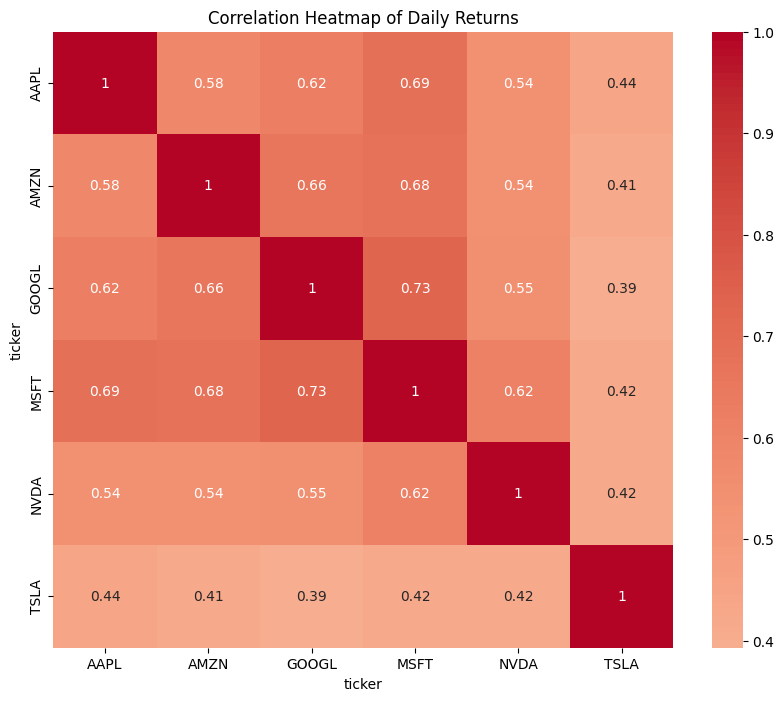

In [108]:
corr = rets.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm",center=0)
plt.title("Correlation Heatmap of Daily Returns")
plt.show()

---

## Findings

- NVIDIA delivered the highest annualised return at 78% but also carried very high volatility at 50%. Despite this, it achieved the best Sharpe ratio at 1.56, meaning strong risk-adjusted performance.
- Microsoft showed more moderate returns at 29% with relatively low volatility at 27%, giving it a solid Sharpe ratio of 1.07, highlighting a balance between return and risk.
- Apple, Amazon, and Google produce comparable returns (20% - 24%) with volatilities around 29%, resulting in Sharpe ratios between 0.68 and 0.83.
- Tesla had relatively high returns at 35% but extremely high volatility at 59%, leading to the weakest Sharpe ratio of 0.58.
- Drawdowns: Microsoft experienced the deepest drawdown (-26%) in the sample, while Tesla also saw large peak-to-trough declines (-13%). In contrast, NVIDIA’s worst drawdown was relatively modest (-2.7%), suggesting faster recovery from downturns.
- Top 3 drawdowns: Across all tickers, drawdowns often clustered around 2015–2016, with recovery periods stretching up to a year or more. This highlights how long tech stocks can stay underwater after sharp declines.
- Correlations: Daily returns of the mega-cap tech stocks are highly correlated (0.6–0.7 between most pairs, especially MSFT-GOOGL at 0.73). Tesla stands out as less correlated (~0.4 with most others), meaning it behaves more independently within the group.

In conclusion, while NVIDIA provided the strongest risk-adjusted returns, it also showed resilience with relatively small drawdowns. Microsoft balanced returns and volatility well, though it suffered the largest single drawdown. Tesla was the riskiest with big returns but big drawdowns and the weakest Sharpe ratio. The high correlations among AAPL, MSFT, GOOGL, AMZN, and NVDA suggest limited diversification benefits within this tech basket, while Tesla could add some diversification due to its lower correlation.

---

## Next Steps

- Extend the analysis by adding technical indicators such as RSI and Bollinger Bands.  
- Return Histograms with mean/std lines.